In [1]:
import torch
import torch.nn as nn
from hyperparams_and_args import get_argparser, data_dir
from ninolearn.IO.read_processed import data_reader
from data_handler import DataLoaderS
from GNN_model1.train_model import main, evaluate
from plotting import plot_time_series, heatmap_of_edges
from utils import read_ssta
import warnings
warnings.filterwarnings("ignore")  # or use: "once"

## GNN1:
#### Uses only reconstructed observational data (ERSSTv5), and the 33 ONI/Nino3.4 region nodes (at a dataset resolution of 5deg.).

In [2]:
model_dir = "models/"

In [3]:
train_dates = ("1871-01", "1972-12")
val_dates   = ("1973-01", "1983-12")
test_dates  = ("1984-01", "2020-08")
parser = get_argparser(experiment="ERSSTv5")
args = parser.parse_args("")
args.data_dir = data_dir
args.batch_size = 32
args.resolution = 5
args.lon_min = 190  # In east
args.lon_max = 240  # In east
args.lat_min = -5
args.lat_max = 5
args.window = 3  # use 3 past timesteps for a forecast of horizon months ahead.
args.layers = 2  # GNN layers
args.lr = 1e-4
args.prelu = True  # use PReLU activation function
args.dropout = 0.1

In [4]:
def train_exp1(args, reader):
    print(f"#Lead months = {args.horizon}, #layers = {args.layers}, Inputs between "
          f"{args.lat_min} to {args.lat_max} latitude and {args.lon_min} to {args.lon_max} longitude "
          f"for the past {args.window} months")

    flattened_ssta, train_mask = read_ssta(data_dir=args.data_dir, index=args.index, get_mask=True, resolution=args.resolution, reader=reader)
    args.mask = train_mask  # usually to mask out those nodes corresponding to the ONI region

    print("Model will be saved in", args.save)  # best model w.r.t. to validation rmse is saved
    main(args, adj=None, train_dates=train_dates, val_dates=val_dates, test_dates=test_dates)  # learn edges


In [5]:
def eval_model(args):
    model = torch.load(args.save)
    model.eval()

    evaluateL2 = nn.MSELoss().to(args.device)
    evaluateL1 = nn.L1Loss().to(args.device)

    Data = DataLoaderS(args, train_dates=train_dates, val_dates=val_dates, test_dates=test_dates)
    test_acc, test_rae, test_corr, oni_test_stats, preds, Ytrue = evaluate(Data, Data.test[0], Data.test[1],
                                                                               model, evaluateL2, evaluateL1, args,
                                                                               return_oni_preds=True)
    print("Exp1 Test stats... OVERALL: rse {:5.4f} , RMSE {:5.4f} , corr {:5.4f}"
                    " | ONI:  RMSE {:5.4f} , corr {:5.4f}"
          .format(test_acc, test_rae, test_corr, oni_test_stats["RMSE"], oni_test_stats["Corrcoef"]))
    return preds, Ytrue, Data.semantic_time_steps['test']

In [6]:
def train_and_eval(args):
    reader = data_reader(data_dir=data_dir,
                         startdate=train_dates[0], enddate=test_dates[1],
                         lon_min=args.lon_min, lon_max=args.lon_max,
                         lat_min=args.lat_min, lat_max=args.lat_max)

    train_exp1(args, reader=reader)

    # Eval test scores
    preds, Y, time_axis = eval_model(args)

    # Plot learned edges
    heatmap_of_edges(file_path=args.save, reader=reader, min_weight=1e-4, data_dir=data_dir)

    # PLot ONI timeseries
    oni_preds, oni_Y = preds.mean(axis=1), Y.mean(axis=1)
    plot_time_series(oni_Y, oni_preds, time_steps=time_axis, labels=["ERSSTv5 ONI", "GNN Forecast"],
                     ylabel=f"{args.index} index",  save_to=None)


### 1 lead month experiment

#Lead months = 1, #layers = 2, Inputs between -5 to 5 latitude and 190 to 240 longitude for the past 3 months
Model will be saved in models/exp1/1mon_lead
Training, Validation, Test samples = 1222, 127, 435, #nodes = 33, predicting 1 time steps in advance using 3 time steps. 

The receptive field size is 19
Number of model parameters is 27969
begin training
--> Epoch   1 | time:  3.73s | train_loss 0.9605 | Val. loss 0.0258, corr 0.8425 | ONI corr 0.8818, RMSE 0.7705
Model will be saved...
--> Epoch   2 | time:  3.79s | train_loss 0.5559 | Val. loss 0.0214, corr 0.8961 | ONI corr 0.9111, RMSE 0.6361
Model will be saved...
--> Epoch   3 | time:  3.79s | train_loss 0.3089 | Val. loss 0.0153, corr 0.8977 | ONI corr 0.9037, RMSE 0.4349
Model will be saved...
--> Epoch   4 | time:  3.94s | train_loss 0.1642 | Val. loss 0.0123, corr 0.9121 | ONI corr 0.9151, RMSE 0.3393
Model will be saved...
--> Epoch   5 | time:  3.72s | train_loss 0.1073 | Val. loss 0.0108, corr 0.9328 | ONI corr 0.9352, 

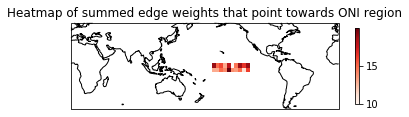

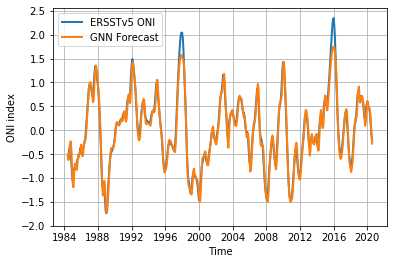

In [7]:
args.horizon = 1
args.epochs = 25
args.save = model_dir + "1mon_lead"
train_and_eval(args)

### 3 lead months experiment

#Lead months = 3, #layers = 2, Inputs between -5 to 5 latitude and 190 to 240 longitude for the past 3 months
Model will be saved in models/exp1/3mon_lead
Training, Validation, Test samples = 1222, 125, 433, #nodes = 33, predicting 3 time steps in advance using 3 time steps. 

The receptive field size is 19
Number of model parameters is 27969
begin training
--> Epoch   1 | time:  3.56s | train_loss 0.5626 | Val. loss 0.0223, corr 0.7830 | ONI corr 0.7995, RMSE 0.6457
Model will be saved...
--> Epoch   2 | time:  3.69s | train_loss 0.3863 | Val. loss 0.0188, corr 0.7757 | ONI corr 0.7891, RMSE 0.5304
Model will be saved...
--> Epoch   3 | time:  3.84s | train_loss 0.3176 | Val. loss 0.0175, corr 0.7940 | ONI corr 0.8081, RMSE 0.4876
Model will be saved...
--> Epoch   4 | time:  3.66s | train_loss 0.3065 | Val. loss 0.0165, corr 0.8227 | ONI corr 0.8391, RMSE 0.4577
Model will be saved...
--> Epoch   5 | time:  3.55s | train_loss 0.3134 | Val. loss 0.0157, corr 0.8454 | ONI corr 0.8650, 

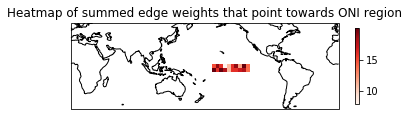

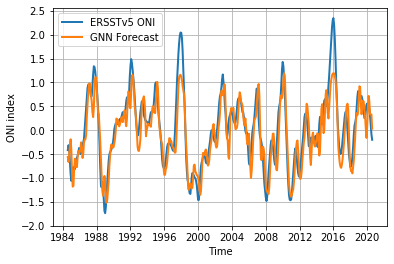

In [8]:
args.horizon = 3
args.epochs = 50
args.save = model_dir + "3mon_lead"
train_and_eval(args)

### 6 lead months experiment

#Lead months = 6, #layers = 2, Inputs between -5 to 5 latitude and 190 to 240 longitude for the past 3 months
Model will be saved in models/exp1/6mon_lead
Training, Validation, Test samples = 1222, 122, 430, #nodes = 33, predicting 6 time steps in advance using 3 time steps. 

The receptive field size is 19
Number of model parameters is 27969
begin training
--> Epoch   1 | time:  3.48s | train_loss 0.7149 | Val. loss 0.0251, corr 0.4686 | ONI corr 0.5011, RMSE 0.7183
Model will be saved...
--> Epoch   2 | time:  3.78s | train_loss 0.5780 | Val. loss 0.0248, corr 0.5027 | ONI corr 0.5359, RMSE 0.7028
Model will be saved...
--> Epoch   3 | time:  3.64s | train_loss 0.5405 | Val. loss 0.0234, corr 0.5739 | ONI corr 0.6049, RMSE 0.6566
Model will be saved...
--> Epoch   4 | time:  3.64s | train_loss 0.5208 | Val. loss 0.0228, corr 0.6076 | ONI corr 0.6387, RMSE 0.6347
Model will be saved...
--> Epoch   5 | time:  3.57s | train_loss 0.5089 | Val. loss 0.0227, corr 0.6287 | ONI corr 0.6629, 

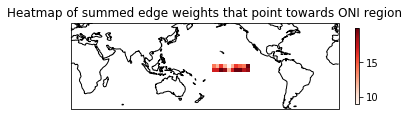

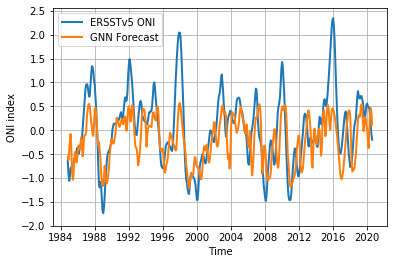

In [9]:
args.horizon = 6
args.epochs = 50
args.save = model_dir + "6mon_lead"
train_and_eval(args)

### Reload a model as follows:

In [ ]:
model = torch.load("models/1mon_lead_33nodes.pt")
eval_model(model.args)